<a href="https://colab.research.google.com/github/Saurav-VK/Lunar_Crater_Detection/blob/main/CRATER_DETECTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

In [ ]:
# Constants for scale
PIXEL_SCALE = 0.25  # meters per pixel assuming that the area of each image is 3km * 1km
MIN_AREA_PIXELS = 300  # Minimum area in pixels to consider a crater as 'large'

In [ ]:

def detect_dark_craters(image_path):
    # Load the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Apply thresholding for dark craters
    threshold_value = 15
    _, dark_thresh = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY_INV)

    return image, dark_thresh



In [ ]:

def detect_bright_boulders(image_path):
    # Load the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Apply thresholding for bright areas (boulders)
    threshold_value = 200
    _, bright_thresh = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY)

    # Remove small artifacts using morphological operations
    kernel = np.ones((3, 3), np.uint8)
    bright_thresh = cv2.morphologyEx(bright_thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    bright_thresh = cv2.morphologyEx(bright_thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

    return bright_thresh

In [ ]:
def highlight_patches_on_original(original_image, dark_thresholded_image, bright_thresholded_image):
    # Convert original image to BGR (to display colored contours)
    original_image_bgr = cv2.cvtColor(original_image, cv2.COLOR_GRAY2BGR)

    # Find contours in the thresholded images
    dark_contours, _ = cv2.findContours(dark_thresholded_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bright_contours, _ = cv2.findContours(bright_thresholded_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw all dark contours in green and bright contours in blue on the original image
    cv2.drawContours(original_image_bgr, dark_contours, -1, (0, 255, 0), 2)
    cv2.drawContours(original_image_bgr, bright_contours, -1, (255, 0, 0), 2)

    # Calculate and display area of large craters
    calculate_and_display_large_crater_areas(original_image_bgr, dark_contours)

    # Display the image with highlighted patches
    cv2_imshow(original_image_bgr)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


In [ ]:
import numpy as np

# Define a list of colors (in BGR format) for highlighting
COLORS = [
    (255, 0, 255),  # Pink
    (255, 0, 0),    # Blue
    (255, 255, 0),  # Cyan
    (0, 0, 255)     # Red
]

def calculate_and_display_large_crater_areas(image, contours):
    for i, contour in enumerate(contours):
        # Calculate the area of the contour
        area_pixels = cv2.contourArea(contour)

        # Check if the area exceeds the minimum threshold
        if area_pixels > MIN_AREA_PIXELS:
            # Convert area from pixels to square meters
            area_meters = area_pixels * (PIXEL_SCALE ** 2)

            # Calculate the center of the contour
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
            else:
                cX, cY = 0, 0

            # Select a color from the list
            color = COLORS[i % len(COLORS)]

            # Draw the contour with the selected color
            cv2.drawContours(image, [contour], -1, color, 2)

            # Draw a thinner pointer and annotate the area with a background box
            pointer_start = (cX, cY)
            pointer_end = (cX, cY + 30)  # Pointer pointing downwards
            cv2.line(image, pointer_start, pointer_end, (0, 255, 255), 1)  # Thinner yellow pointer

            # Text box
            text = f'{area_meters:.2f} sq.m'
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.4  # Smaller font size
            font_color = (0, 0, 255)  # Red text
            thickness = 1  # Thinner font
            text_size, _ = cv2.getTextSize(text, font, font_scale, thickness)
            text_w, text_h = text_size
            box_coords = (cX - text_w // 2 - 5, cY + 50 - text_h - 10)
            box_coords_end = (cX + text_w // 2 + 5, cY + 50 + 10)

            # Draw text background box
            cv2.rectangle(image, box_coords, box_coords_end, (0, 0, 0), -1)  # Black background box

            # Put text on image
            cv2.putText(image, text, (cX - text_w // 2, cY + 50), font, font_scale, font_color, thickness)

In [ ]:
# Function to draw bounding boxes from CSV file
def draw_and_display_bounding_boxes(csv_file, image_path):
    # Load the CSV file
    df = pd.read_csv(csv_file)

    # Read the image
    image = cv2.imread(image_path)

    # Get the filename from the image path
    filename = image_path.split('/')[-1]

    # Filter the dataframe for the specific image
    image_df = df[df['filename'] == filename]

    # Draw bounding boxes
    for _, row in image_df.iterrows():
        xmin, ymin, xmax, ymax = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)  # Green box with thickness of 2

    return image  # Return the image with bounding boxes

In [ ]:
# Function to draw bounding boxes for large craters
def draw_bounding_boxes_for_large_craters(original_image, dark_thresholded_image):
    # Convert original image to BGR (to display colored contours)
    image_bgr = cv2.cvtColor(original_image, cv2.COLOR_GRAY2BGR)

    # Find contours in the thresholded image for dark craters
    dark_contours, _ = cv2.findContours(dark_thresholded_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Define color for bounding boxes
    box_color = (0, 0, 255)  # Red color for bounding boxes
    box_thickness = 2  # Thickness of the bounding box lines

    # Iterate over contours to calculate bounding boxes
    for contour in dark_contours:
        # Calculate the area of the contour
        area_pixels = cv2.contourArea(contour)

        # Only draw bounding boxes for large craters
        if area_pixels > MIN_AREA_PIXELS:
            # Calculate bounding box
            x, y, w, h = cv2.boundingRect(contour)

            # Draw the bounding box on the image
            cv2.rectangle(image_bgr, (x, y), (x + w, y + h), box_color, box_thickness)

    return image_bgr  # Return the image with bounding boxes

In [ ]:
# Function to display images side by side with labels
def display_side_by_side(image1, image2, label1, label2, space_width=50):
    # Resize images to the same height for a uniform display
    height1, width1 = image1.shape[:2]
    height2, width2 = image2.shape[:2]

    # Resize the second image to match the height of the first image
    if height1 != height2:
        width2 = int(width2 * (height1 / height2))
        image2 = cv2.resize(image2, (width2, height1))

    # Create a blank image with the same height as the input images and the width for the space
    blank_space = np.ones((height1, space_width, 3), dtype=np.uint8) * 255  # White space

    # Concatenate images horizontally with space in between
    combined_image = np.hstack((image1, blank_space, image2))

    # Add labels
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    font_color = (255, 255, 255)  # White color
    thickness = 2

    # Add text to the left side image
    cv2.putText(combined_image, label1, (5, 25), font, font_scale, font_color, thickness, cv2.LINE_AA)

    # Add text to the right side image
    cv2.putText(combined_image, label2, (width1 + space_width + 5, 25), font, font_scale, font_color, thickness, cv2.LINE_AA)

    # Display the combined image
    cv2_imshow(combined_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

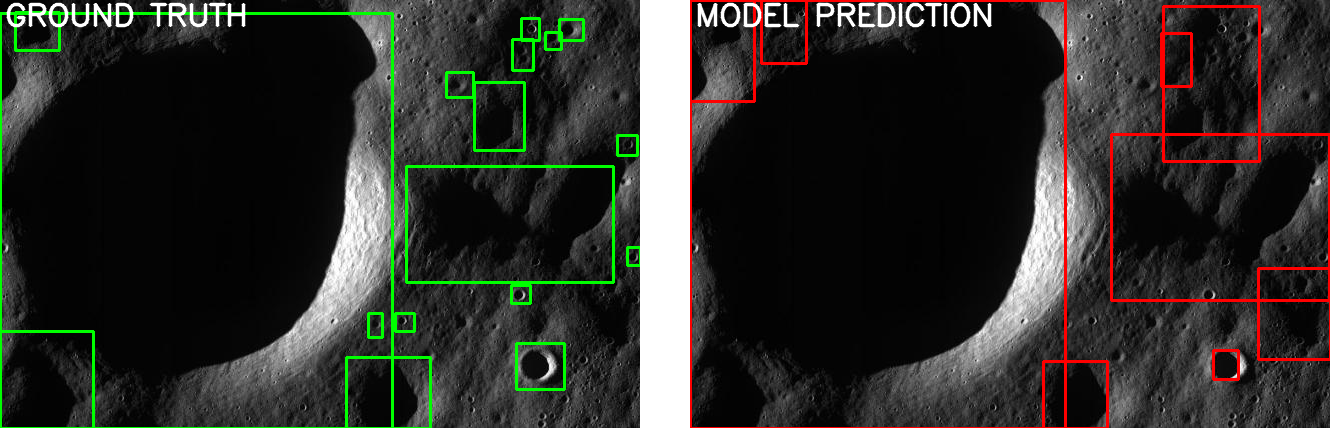

In [ ]:
# Example usage
csv_file_path = '/content/drive/MyDrive/ISRO/train/_annotations.csv'
image_path = '/content/drive/MyDrive/ISRO/train/56_jpg.rf.0543da623b2795c354013d5b7ad87a3c.jpg'

# Get ground truth bounding boxes
ground_truth_image = draw_and_display_bounding_boxes(csv_file_path, image_path)

# Load the grayscale image and detect craters
original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
dark_thresholded_image = detect_dark_craters(image_path)[1]
bright_thresholded_image = detect_bright_boulders(image_path)

# Get model prediction bounding boxes
model_prediction_image = draw_bounding_boxes_for_large_craters(original_image, dark_thresholded_image)

# Display side by side
display_side_by_side(ground_truth_image, model_prediction_image, "GROUND TRUTH", "MODEL PREDICTION")

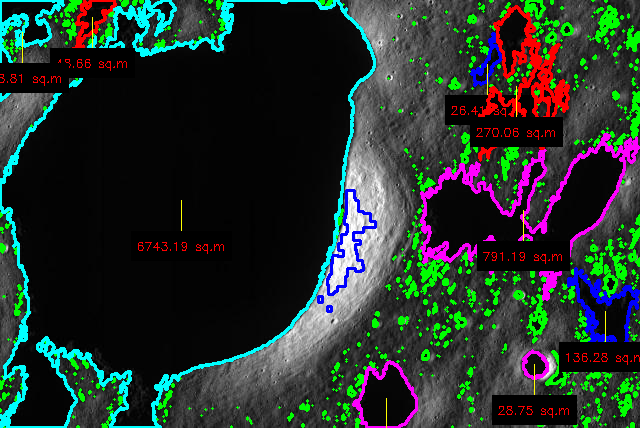

In [ ]:

# Path to the images
image_path = '/content/drive/MyDrive/ISRO/train/56_jpg.rf.0543da623b2795c354013d5b7ad87a3c.jpg'

# Detect dark craters and get the thresholded image
original_image, dark_thresholded_image = detect_dark_craters(image_path)

# Detect bright boulders and get the thresholded image
bright_thresholded_image = detect_bright_boulders(image_path)

# Highlight the dark craters and bright boulders on the original image
highlight_patches_on_original(original_image, dark_thresholded_image, bright_thresholded_image)

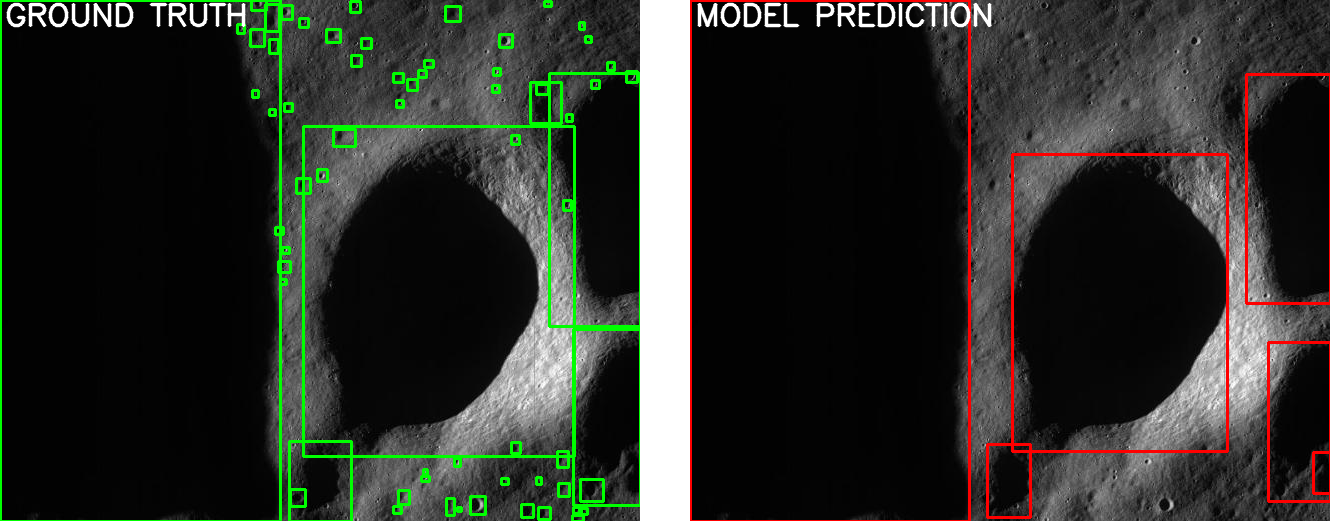

In [ ]:
# Example usage
csv_file_path = '/content/drive/MyDrive/ISRO/train/_annotations.csv'
image_path = '/content/drive/MyDrive/ISRO/train/55_jpg.rf.1ec003195178ff3116f1f0666c9eca72.jpg'

# Get ground truth bounding boxes
ground_truth_image = draw_and_display_bounding_boxes(csv_file_path, image_path)

# Load the grayscale image and detect craters
original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
dark_thresholded_image = detect_dark_craters(image_path)[1]
bright_thresholded_image = detect_bright_boulders(image_path)

# Get model prediction bounding boxes
model_prediction_image = draw_bounding_boxes_for_large_craters(original_image, dark_thresholded_image)

# Display side by side
display_side_by_side(ground_truth_image, model_prediction_image, "GROUND TRUTH", "MODEL PREDICTION")

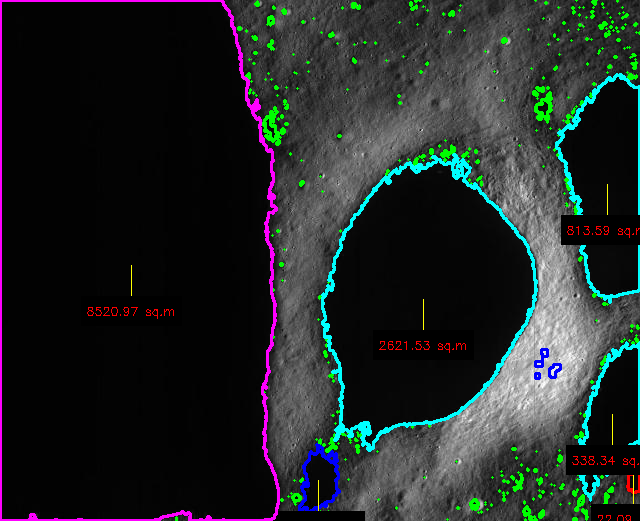

In [ ]:
# Path to the images
image_path = '/content/drive/MyDrive/ISRO/train/55_jpg.rf.1ec003195178ff3116f1f0666c9eca72.jpg'

# Detect dark craters and get the thresholded image
original_image, dark_thresholded_image = detect_dark_craters(image_path)

# Detect bright boulders and get the thresholded image
bright_thresholded_image = detect_bright_boulders(image_path)

# Highlight the dark craters and bright boulders on the original image
highlight_patches_on_original(original_image, dark_thresholded_image, bright_thresholded_image)